In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sktime.forecasting.compose import make_reduction
from sklearn.preprocessing import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,TimeSeriesSplit


def categorize_time(X):
    """
    Categorize times of the day into predefined intervals.

    This function takes a DataFrame and applies a categorization based on the 'hour'
    column of the DataFrame, assigning a time category label to each row.

    Parameters:
    X (pandas.DataFrame): A DataFrame with an 'hour' column that contains integer values
                           representing the hour of the day (24-hour format).

    Returns:
    pandas.DataFrame: The original DataFrame with a new column 'time_category' added,
                      containing the categorical time labels for each row.

    """

    def categorize(hour):
        # Inner function to categorize a single hour
        if 5 <= hour < 9:
            return '5-9'
        elif 9 <= hour < 14:
            return '9-14'
        elif 14 <= hour < 21:
            return '14-21'
        elif 21 <= hour or hour < 5:
            return '21-5'
        
    X['time_category'] = X['hour'].apply(categorize)
    return X


def categorize_rainfall(X):
    """
    Categorize rainfall levels into categories.

    This function modifies the input DataFrame by adding a new column 'rainfall_category'.
    The category is determined based on the value of 'rain_l_1' column, which is assumed
    to represent rainfall levels. The categories are defined as follows:
    - Category 0: No rain or 'rain_l_1' column not present.
    - Category 1: Rainfall level is between 0 and 4000 inclusive.
    - Category 2: Rainfall level is greater than 4000.

    Parameters:
    X (pandas.DataFrame): A DataFrame with a column 'rain_l_1' that contains numerical
                           values representing rainfall levels.

    Returns:
    pandas.DataFrame: The DataFrame with an additional column 'rainfall_category',
                      containing the categorical labels based on rainfall levels.

    Raises:
    KeyError: If the 'rain_l_1' column is missing from the DataFrame.
    """
    X['rainfall_category'] = 0 

    X.loc[(X['rain_l_1'] > 0) & (X['rain_l_1'] <= 4000), 'rainfall_category'] = 1

    X.loc[X['rain_l_1'] > 4000, 'rainfall_category'] = 2

    return X



    
conf = [(datetime(2020, 3, 17), datetime(2020, 5, 10)), (datetime(2020, 10, 30), datetime(2020, 11, 27)), (datetime(2021, 4, 3), datetime(2021, 5, 2))]
conf_a = [(datetime(2020, 5, 11), datetime(2020, 6, 1)), (datetime(2020, 11, 28), datetime(2020, 12, 15))]
c_v = [(datetime(2020,10,15), datetime(2020,10,29)), (datetime(2020, 12, 16), datetime(2021, 4, 2)), (datetime(2021, 5, 3), datetime(2021, 6, 20))]

def is_in_range(date):
    """
    Determine the confinement status for a given date.

    The function checks if the given date falls within any of the confinement periods
    specified in 'conf', 'conf_a', or 'c_v'. It also checks for a specific date
    (December 25, 2020) which has a unique status. 

    Parameters:
    date (datetime.datetime): The date to check.

    Returns:
    int: A status code where 1 indicates the date is within a confinement period,
         2 indicates the date is December 25, 2020, and 0 indicates the date is
         outside of any confinement period.
    """
    
    
    for start, end in conf:
        if start <= date <= end:
            return 1
    for start, end in conf_a:
        if start <= date <= end:
            return 1
    for start, end in c_v:
        if start <= date <= end:
            return 1
    if date == datetime(2020, 12, 25):
        return 2
    else:
        return 0

def apply_confinement_status(X) :
    """
    Apply confinement status to each row in a DataFrame based on the 'date' column.

    This function creates a copy of the input DataFrame and adds a new column 'Confinement',
    which indicates the confinement status of each date using the 'is_in_range' function.

    Parameters:
    X (pandas.DataFrame): A DataFrame with a 'date' column containing datetime.datetime objects.

    Returns:
    pandas.DataFrame: The original DataFrame with an additional 'Confinement' column.
    """
    X = X.copy()  
    X['Confinement'] = X['date'].apply(is_in_range)
    return X


def _encode_dates(X):
    """
    Encode date-time features from the 'date' column of a DataFrame.

    This function creates a copy of the input DataFrame and extracts various date-time components
    such as year, month, day, weekday, and hour from the 'date' column, adding each as a new column.

    Parameters:
    X (pandas.DataFrame): A DataFrame with a 'date' column in a format recognized by pandas.to_datetime.

    Returns:
    pandas.DataFrame: A DataFrame with new columns for year, month, day, weekday, and hour.
    """
    
    X = X.copy()
    X['date'] = pd.to_datetime(X['date'])
    X['year'] = X['date'].dt.year
    X['month'] = X['date'].dt.month
    X['day'] = X['date'].dt.day
    X['weekday'] = X['date'].dt.weekday
    X['hour'] = X['date'].dt.hour
    return X

def encode_season(X):
    
    """
    Add a 'season' column to a DataFrame based on the month.

    This function maps each month to a season ('Winter', 'Spring', 'Summer', 'Autumn')
    and adds this information as a new 'season' column in the DataFrame.

    Parameters:
    X (pandas.DataFrame): A DataFrame with a 'month' column containing integer values from 1 to 12.

    Returns:
    pandas.DataFrame: The original DataFrame with an additional 'season' column.
    """
    X = X.copy()  
    X['season'] = X['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] 
                                          else 'Spring' if x in [3, 4, 5] 
                                          else 'Summer' if x in [6, 7, 8] 
                                          else 'Autumn')
    
    return X

def split_address_and_map_direction(X):
    
    """
    Split 'counter_name' into 'Address' and 'Direction' and map the direction.

    This function splits the 'counter_name' column of the DataFrame into two columns: 'Address'
    and 'Direction'. It then maps the values in 'Direction' to numerical codes based on a predefined
    mapping and fills missing values with a default code.

    Parameters:
    X (pandas.DataFrame): A DataFrame with a 'counter_name' column containing address and direction.

    Returns:
    pandas.DataFrame: The DataFrame with new 'Address' and 'Direction' columns.
    """

    X[['Address', 'Direction']] = X['counter_name'].str.rsplit(' ', n=1, expand=True)

    direction_mapping = {
        'E-O': 1, 'O-E': -1, 'NO-SE': 1, 'SE-NO': -1, 'SO-NE': 1, 'SE-NO': -1, 'N-S': 1, 'S-N': -1,
    }

    X['Direction'] = X['Direction'].map(direction_mapping)
    X['Direction'].fillna(1, inplace=True)

    return X




def _distance_from_paris_centre(X):
    
    """
    Calculate the distance of each row from the centre of Paris.

    This function computes the Euclidean distance from the centre of Paris (fixed latitude and longitude)
    for each row in the DataFrame based on its latitude and longitude and adds this as a new column.

    Parameters:
    X (pandas.DataFrame): A DataFrame with 'latitude' and 'longitude' columns.

    Returns:
    pandas.DataFrame: The DataFrame with an additional 'distance_paris_centre' column.
    """
    
    X = X.copy() 
    X.loc[:, 'distance_paris_centre'] = np.sqrt((X['latitude']-48.8565)*2 + (X['longitude']-2.3426)*2)
    
    return X



def covid_scaled_count(X):
    """
    Apply COVID-19 impact scaling factors to bike counts during confinement and couvre-feu periods.

    This function modifies the input DataFrame by scaling the 'bike_count' column based on predefined
    impact factors during specific date ranges for confinements (conf) and couvre-feu (c_v).
    The scaled counts are stored in a new column 'scaled_bike_count'.

    Parameters:
    X (pandas.DataFrame): A DataFrame with 'bike_count' and 'date' columns, where 'date' is in datetime format.

    Returns:
    pandas.DataFrame: The original DataFrame with an additional 'scaled_bike_count' column reflecting the
                      scaled bike counts during COVID-19 related periods.
    """

    X = X.copy()

    # Define the COVID impact factors
    covid_impact_conf = 1.23
    covid_impact_cv = 1.16

    # Define date ranges for confinements (conf) and couvre-feu (c_v)
    conf = [(datetime(2020, 10, 30), datetime(2020, 12, 15)), (datetime(2021, 4, 3), datetime(2021, 5, 2))]
    c_v = [(datetime(2020, 10, 15), datetime(2020, 10, 29)), (datetime(2020, 12, 16), datetime(2021, 4, 2)), (datetime(2021, 5, 3), datetime(2021, 6, 20))]

    # Initialize a column for scaled bike counts
    X['scaled_bike_count'] = X['bike_count']

    # Apply the conf impact factor
    for start, end in conf:
        conf_mask = (X['date'] >= start) & (X['date'] <= end)
        X.loc[conf_mask, 'scaled_bike_count'] *= covid_impact_conf

    # Apply the c_v impact factor
    for start, end in c_v:
        cv_mask = (X['date'] >= start) & (X['date'] <= end)
        X.loc[cv_mask, 'scaled_bike_count'] *= covid_impact_cv

    return X

def covid_scaled_log_count(X):
    """
    Apply a logarithmic transformation to the scaled bike counts.

    This function takes the 'scaled_bike_count' column from the input DataFrame,
    applies a natural logarithmic transformation (ln(x+1)), and stores the result in a new
    column 'scaled_log_bike_count'.

    Parameters:
    X (pandas.DataFrame): A DataFrame with a 'scaled_bike_count' column containing numerical values.

    Returns:
    pandas.DataFrame: The original DataFrame with an additional 'scaled_log_bike_count' column.
    """
    
    X = X.copy()
    # Apply ln(x+1) transformation to the scaled_bike_count
    X['scaled_log_bike_count'] = np.log1p(X['scaled_bike_count'])
    return X




###########
def calculate_time_since_installation(X):
    
    
    """
    Calculate the time since installation for each counter in a DataFrame.

    This function adds a new column 'Time_since_installation' to the DataFrame, representing
    the number of days elapsed since the installation date of each counter. The calculation is
    based on the 'date' column and the 'counter_installation_date' column in the DataFrame.

    Parameters:
    X (pandas.DataFrame): A DataFrame with 'date' and 'counter_installation_date' columns. The 'date'
                          column should be in datetime format.

    Returns:
    pandas.DataFrame: The original DataFrame with an additional 'Time_since_installation' column.
    """
    
    X = X.copy() 
    X['counter_installation_date'] = pd.to_datetime(X['counter_installation_date'])
    X['Time_since_installation'] = X['date'].dt.date - X['counter_installation_date'].dt.date
    X['Time_since_installation'] = X['Time_since_installation'].apply(lambda x: x.days)
    return X


def get_elevation_for_dataframe(X):
    
    
    """
    Retrieve elevation data for each row in a DataFrame based on latitude and longitude coordinates.

    This function queries an external API to obtain elevation data for each unique pair of latitude
    and longitude in the DataFrame. It then maps this elevation data back to the original DataFrame.

    Parameters:
    X (pandas.DataFrame): A DataFrame with 'latitude' and 'longitude' columns.

    Returns:
    pandas.DataFrame: The original DataFrame with an additional 'Elevation' column containing the
                      elevation data for each row.

    Note:
    This function requires an internet connection to access the elevation API and may take some time
    to run for large DataFrames due to API request limits.
    """
    
    
   
    def get_elevation(lat, lon):
        url = f"https://api.open-elevation.com/api/v1/lookup?locations={lat},{lon}"
        response = requests.get(url)
        if response.status_code == 200:
            elevation = response.json()['results'][0]['elevation']
            return elevation
        else:
            return None  # Return None or a default value if the API call fails

    # Get unique latitude-longitude pairs
    unique_lat_lon = X[['latitude', 'longitude']].drop_duplicates()

    # Get elevation for each unique pair
    unique_lat_lon['elevation'] = unique_lat_lon.apply(lambda row: get_elevation(row['latitude'], row['longitude']), axis=1)

   
    elevation_dict = dict(zip(unique_lat_lon['latitude'], unique_lat_lon['elevation']))

    # Map the elevation to the DataFrame
    X['Elevation'] = X['latitude'].map(elevation_dict)

    return X


def is_holiday_and_weekend(X):
    
    """
    Identify weekends and proximity to Christmas in a DataFrame.

    This function adds two columns to the DataFrame: 'near_christmas' and 'is_weekend'.
    The 'near_christmas' column indicates whether a date is within 5 days before or after Christmas.
    The 'is_weekend' column indicates whether a date falls on a weekend (Saturday or Sunday).

    Parameters:
    X (pandas.DataFrame): A DataFrame with 'year', 'month', 'day', and 'weekday' columns. The 'year', 
                          'month', and 'day' columns are used to construct a 'date' column.

    Returns:
    pandas.DataFrame: The original DataFrame with additional 'near_christmas' and 'is_weekend' columns.

    Note:
    The function currently has commented-out code for public holiday checking using the 'workalendar'
    library. This functionality can be enabled by uncommenting and properly configuring the relevant
    sections.
    """
    
    X = X.copy()
    # Initialize the France calendar from the workalendar library
    #cal = France()

    X['date'] = pd.to_datetime(X[['year', 'month', 'day']])

    # Add a column for public holidays
    #X['is_public_holiday'] = X['date'].apply(lambda x: cal.is_holiday(x)).astype(int)
    
    X['near_christmas'] = X['date'].apply(
    lambda x: (pd.Timestamp(year=x.year, month=12, day=25) - pd.Timedelta(days=5) <= x <= pd.Timestamp(year=x.year, month=12, day=25) + pd.Timedelta(days=5))
    ).astype(int)
    
    # 5 and 6 represent Saturday and Sunday in 'weekday' column
    X['is_weekend'] = X['weekday'].apply(lambda x: x in [5, 6]).astype(int)

    return X


def column_to_drop(X):
    return X.drop(['day','rain_l_1','Address','weekday','date', 'longitude', 'latitude', 'counter_installation_date',
                  'counter_technical_id','counter_id', 'counter_name', 'site_id','average_wind_speed','u','horizontal_visibility'], axis=1)





def combined_transformer(X):
    X = _encode_dates(X)
    #X = _distance_from_paris_centre(X)
    X=categorize_rainfall(X)
    X=encode_season(X)
    #X=categorize_time(X)
    X=apply_confinement_status(X)
    X=split_address_and_map_direction(X)
    X=is_holiday_and_weekend(X)

    X = column_to_drop(X)
    print(X.info())
    return X

class CyclicalEncoder(BaseEstimator, TransformerMixin):
    
    """
    A transformer for encoding cyclical features like hours, days, or months.

    This class encodes cyclical features using sine and cosine transformations. It is
    designed to handle features like 'hour', 'day', and 'month' which have a cyclical nature.

    Methods:
    fit(X, y=None): Returns self, no fitting is done.
    transform(X): Transforms the DataFrame by adding sin and cos encoded columns for
                  each cyclical feature and drops the original column.
    """
    def init(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for column in ['hour']:
            if column in X.columns:
                max_val = X[column].max()
                X[f'sin_{column}'] = np.sin(2 * np.pi * X[column] / max_val)
                X[f'cos_{column}'] = np.cos(2 * np.pi * X[column] / max_val)
                

        return X.drop('hour',axis=1)

def get_estimator():
    cyclical_encoder = CyclicalEncoder()
    data_encoder = FunctionTransformer(combined_transformer)
    categorical_encoder = OneHotEncoder(handle_unknown="ignore")
    target_cols=['site_name']
    categorical_cols = ['month','season']
    standardize_cols = ['Temperature']
    standardizer = StandardScaler()

    preprocessor = ColumnTransformer(
        [
            ("target_enc", TargetEncoder(), target_cols),
            ("stand", standardizer, standardize_cols),
            ("cat", categorical_encoder, categorical_cols),
        ],remainder='passthrough'
    )
    
    
    regressor = XGBRegressor(
        objective='reg:squarederror',
        subsample=0.5,
        reg_alpha = 0,
        reg_lambda= 10,
        n_estimators = 300,
        max_depth = 10,
        learning_rate=0.05,
        gamma=0,
        colsample_bytree= 0.5,
    )

    
    pipe = make_pipeline(data_encoder ,cyclical_encoder, preprocessor, regressor)
    
    return pipe



# Load data
df_train = pd.read_parquet('Data/train.parquet')
df_test = pd.read_parquet("data/test.parquet")

df_train['site_name'] = df_train['site_name'].astype(str)
df_train['site_name'] = df_train['site_name'].replace(r'^Pont des Invalides (S-N|N-S)$', 'Pont des Invalides', regex=True)
df_train['site_name'] = df_train['site_name'].astype('category')

df_test['site_name'] = df_test['site_name'].astype(str)
df_test['site_name'] = df_test['site_name'].replace(r'^Pont des Invalides (S-N|N-S)$', 'Pont des Invalides', regex=True)
df_test['site_name'] = df_test['site_name'].astype('category')


### IMPLEMENT SCALED FACTOR FOR COVID on df_train
# Load training and test datasets from Parquet files
df_train = pd.read_parquet('Data/train.parquet')
df_test = pd.read_parquet("data/test.parquet")

# Convert 'site_name' to string and standardize its format in both datasets
df_train['site_name'] = df_train['site_name'].astype(str)
df_train['site_name'] = df_train['site_name'].replace(r'^Pont des Invalides (S-N|N-S)$', 'Pont des Invalides', regex=True)
df_train['site_name'] = df_train['site_name'].astype('category')

df_test['site_name'] = df_test['site_name'].astype(str)
df_test['site_name'] = df_test['site_name'].replace(r'^Pont des Invalides (S-N|N-S)$', 'Pont des Invalides', regex=True)
df_test['site_name'] = df_test['site_name'].astype('category')

# Apply COVID-19 impact scaling factors to 'bike_count' in df_train
df_train = covid_scaled_count(df_train)
df_train = covid_scaled_log_count(df_train)

# Load external weather data from a CSV file
weather = pd.read_csv("data/external_data.csv", sep='or|,+', engine='python')
# Select specific columns from the weather data
weather = weather[['date', 't', 'ff', 'vv', 'u', 'rr1']]

# Rename columns for clarity
new_name = {'t': 'Temperature', 'ff': 'average_wind_speed', 'vv': 'horizontal_visibility', 'rr1': 'rain_l_1'}
weather.rename(columns=new_name, inplace=True)

#fill missing values in 'rain_l_1'
weather['rain_l_1'].bfill(inplace=True)

# Convert 'date' to datetime format
weather['date'] = pd.to_datetime(weather['date'])

# Define a date range for filtering
start_date = datetime.strptime('2020-09-01 01:00:00', "%Y-%m-%d %H:%M:%S")
end_date = datetime.strptime('2021-09-09 23:00:00', "%Y-%m-%d %H:%M:%S")

# Filter the weather data based on the defined date range
weather_train = weather[(start_date <= weather['date']) & (weather['date'] <= end_date)]

# Create a copy of the filtered weather data
weather_train = weather_train.copy()

# Drop a specific row by its index
weather_train.drop(2018, inplace=True)

# Set 'date' as the index and resample the data to hourly frequency, forward filling missing values
weather_train = weather_train.set_index('date')
df_hourly = weather_train.resample('H').ffill()

# Reset the index to turn 'date' back into a column
weather_hourly = df_hourly.reset_index()

# Merge df_train with the resampled hourly weather data on 'date'
df_train.reset_index(inplace=True)
df_train = pd.merge(df_train, weather_hourly, on='date')

# Set 'index' as the index for df_train and sort it
df_train.set_index('index', inplace=True)
df_train = df_train.sort_index()


# Extract features and target
X_train = df_train.drop(columns=['log_bike_count', 'bike_count', 'scaled_bike_count', 'scaled_log_bike_count'])
y_train = df_train['scaled_log_bike_count']

# Train the model with cross-validation
pipeline = get_estimator()


# Assuming 'pipeline' is your model, 'X_train' is your feature set, and 'y_train' is your target variable
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit the model on the training fold
    pipeline.fit(X_train_fold, y_train_fold)

    # Predict on the test fold
    y_pred_fold = pipeline.predict(X_test_fold)
    y_pred=np.maximum(y_pred_fold,0)

    # Calculate RMSE for the current fold
    rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    print(f'RMSE for the fold: {rmse}')

<class 'pandas.core.frame.DataFrame'>
Index: 75845 entries, 48324 to 267785
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   site_name          75845 non-null  category
 1   Temperature        75845 non-null  float64 
 2   year               75845 non-null  int32   
 3   month              75845 non-null  int32   
 4   hour               75845 non-null  int32   
 5   rainfall_category  75845 non-null  int64   
 6   season             75845 non-null  object  
 7   Confinement        75845 non-null  int64   
 8   Direction          75845 non-null  float64 
 9   near_christmas     75845 non-null  int64   
 10  is_weekend         75845 non-null  int64   
dtypes: category(1), float64(2), int32(3), int64(4), object(1)
memory usage: 5.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 75842 entries, 267786 to 368617
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  

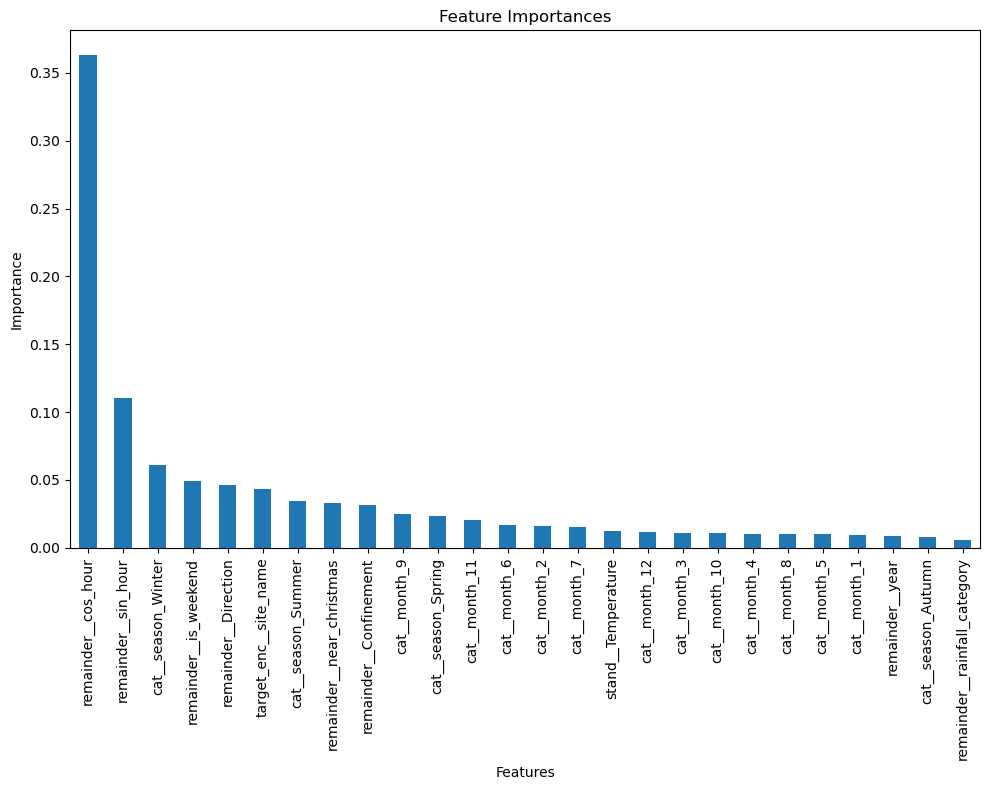

In [2]:
import matplotlib.pyplot as plt

xgb_regressor = pipeline.named_steps['xgbregressor']

feature_importances = xgb_regressor.feature_importances_

# Get feature names from ColumnTransformer
preprocessor = pipeline.named_steps['columntransformer']
feature_names = preprocessor.get_feature_names_out()
all_features = np.array(feature_names)

# Create a pandas series to nicely display feature importances
feature_importance_series = pd.Series(feature_importances, index=all_features)



# Assuming you have your series named 'feature_importance_series'
sorted_series = feature_importance_series.sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sorted_series.plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()  # Adjust layout to fit all labels
plt.savefig('plot_name.jpg', format='jpg')
plt.show()




In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

# Define the hyperparameter grid to search
param_grid = {
    'xgbregressor__max_depth': [3, 5, 7, 10],
    'xgbregressor__n_estimators': [50, 100, 200, 300],
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__subsample': np.linspace(0.5, 1, 5),
    'xgbregressor__colsample_bytree': np.linspace(0.5, 1, 5),
    'xgbregressor__gamma': np.linspace(0, 5, 5),
    'xgbregressor__reg_alpha': [0, 0.001, 0.005, 0.01, 0.05],
    'xgbregressor__reg_lambda': [0.01, 0.1, 1, 10, 100]
    
}

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)


pipeline = get_estimator()

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=50, 
    scoring='neg_mean_squared_error',
    cv=tscv,
    random_state=42,
    verbose=2
)


random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

# Predict using the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_train)

# Evaluate 
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")